In [1]:
"""
Problem Set 1: Standard Incomplete Markets Model
Econ 8861: Monetary Economics I - Spring 2026
Author: Suraj Kumar

This script solves the steady state of the standard incomplete markets model
and generates all figures for the problem set submission.
"""

import sys
sys.path.append('../../Robert  Shared/code/')
import numpy as np
import utils
import matplotlib.pyplot as plt

# =============================================================================
# Model Parameters
# =============================================================================
num_s, num_a = 7, 500      # Number of grid points for income (s) and assets (a)
a_max = 200.               # Upper bound of asset grid
rho, sigma = 0.975, 0.7    # Persistence and unconditional std dev of log(s)

# =============================================================================
# Grid Setup
# =============================================================================
# Discretize income using Rouwenhorst's method (normalized so E[s] = 1)
s_grid, pi_s, Pi = utils.rouwenhorst(rho, sigma, num_s)
# Create exponential asset grid (finer near borrowing constraint)
a_grid = utils.exponential_grid(0, a_max, num_a)


# =============================================================================
# Model Class Definition
# =============================================================================
class IncompleteMarketsModel:
    """
    Standard Incomplete Markets Model with idiosyncratic income risk.

    Households solve:
        V(s, a_-) = max_{a >= a_min} { u(c) + beta * E[V(s', a) | s] }
        s.t. c + a = (1+r)*a_- + s*Y

    Parameters
    ----------
    beta : float
        Discount factor
    r : float
        Interest rate (quarterly)
    Y : float
        Aggregate income normalization
    num_s : int
        Number of income grid points
    num_a : int
        Number of asset grid points
    a_min : float
        Borrowing constraint (lower bound on assets)
    a_max : float
        Upper bound on asset grid
    rho : float
        Persistence of income process
    sigma : float
        Unconditional standard deviation of log income
    """

    def __init__(self, beta=0.988, r=0.01/4, Y=1, num_s=7, num_a=500,
                 a_min=0, a_max=200, rho=0.975, sigma=0.7):
        # Store parameters
        self.beta = beta
        self.r = r
        self.Y = Y
        self.num_s = num_s
        self.num_a = num_a
        self.a_min = a_min
        self.a_max = a_max
        self.rho = rho
        self.sigma = sigma

        # Set up grids using Rouwenhorst method for income
        self.s_grid, self.pi_s, self.Pi = utils.rouwenhorst(rho, sigma, num_s)
        # Exponential grid for assets (finer near constraint)
        self.a_grid = utils.exponential_grid(a_min, a_max, num_a)

    def backward_step(self, par_V_par_a):
        """
        Single backward iteration using the Endogenous Gridpoint Method (EGM).

        Given dV/da (marginal value of assets), computes:
        1. Expected marginal value: E[dV/da | s]
        2. Current consumption from Euler equation
        3. Current assets from budget constraint
        4. Interpolates to get policy on original grid
        5. Enforces borrowing constraint

        Parameters
        ----------
        par_V_par_a : ndarray (num_s, num_a)
            Marginal value of assets dV/da

        Returns
        -------
        par_V_par_a_prev : ndarray (num_s, num_a)
            Updated marginal value dV/da_-
        a_policy : ndarray (num_s, num_a)
            Savings policy a'(s, a_-)
        c_policy : ndarray (num_s, num_a)
            Consumption policy c(s, a_-)
        """
        # Step 1: Compute expected marginal value E[dV/da' | s]
        E_par_V_par_a = self.Pi @ par_V_par_a

        # Step 2: Use Euler equation to get consumption on endogenous grid
        # u'(c) = beta*(1+r)*E[u'(c')] => c = 1/(beta*E[dV/da'])
        c_curr = 1/(self.beta * E_par_V_par_a)

        # Step 3: Use budget constraint to find current assets (endogenous grid)
        # c + a' = (1+r)*a_- + s*Y => a_- = (c + a' - s*Y)/(1+r)
        a_curr = (c_curr + self.a_grid - self.s_grid[:, None]*self.Y)/(1+self.r)

        # Step 4: Interpolate from endogenous grid to original grid
        num_s, num_a = par_V_par_a.shape
        a_next = np.empty((num_s, num_a))
        for i_s in range(num_s):
            utils.interpolate(a_curr[i_s], self.a_grid, self.a_grid, a_next[i_s])

        # Step 5: Enforce borrowing constraint a' >= 0
        a_policy = np.maximum(a_next, 0)

        # Step 6: Compute consumption policy from budget constraint
        c_policy = (1+self.r)*self.a_grid + self.s_grid[:, None]*self.Y - a_policy

        # Step 7: Update marginal value using envelope condition
        # dV/da_- = (1+r)*u'(c) = (1+r)/c
        par_V_par_a_prev = (1+self.r)/c_policy

        return par_V_par_a_prev, a_policy, c_policy

    def forward_step(self, D_init, a_i, a_pi):
        """
        Single forward iteration to update the distribution.

        Uses Young's method: distributes mass across bracketing grid points
        using lottery weights, then updates income state.

        Parameters
        ----------
        D_init : ndarray (num_s, num_a)
            Current distribution over (s, a_-)
        a_i : ndarray (num_s, num_a)
            Index of lower bracketing grid point for a'(s, a_-)
        a_pi : ndarray (num_s, num_a)
            Weight on lower bracketing grid point

        Returns
        -------
        D_next : ndarray (num_s, num_a)
            Updated distribution over (s', a)
        """
        # Initialize end-of-period distribution
        D_end = np.zeros_like(D_init)
        num_s, num_a = D_init.shape

        # Distribute mass according to savings policy
        for i_s in range(num_s):
            for i_a in range(num_a):
                D = D_init[i_s, i_a]        # Mass at current state
                idx = a_i[i_s, i_a]          # Lower grid index for a'
                wt = a_pi[i_s, i_a]          # Weight on lower grid point
                # Distribute mass to bracketing points
                D_end[i_s, idx] += wt * D
                D_end[i_s, idx + 1] += (1 - wt) * D

        # Update income state: D_{t+1} = Pi' * D_end
        D_next = self.Pi.T @ D_end
        return D_next

    def solve(self, tol=1e-6, n_iter_max=500, D_iter_max=500, D_tol=1e-8, verbose=False):
        """
        Solve for steady state: policy functions and stationary distribution.

        Parameters
        ----------
        tol : float
            Convergence tolerance for backward iteration
        n_iter_max : int
            Maximum backward iterations
        D_iter_max : int
            Maximum forward iterations
        D_tol : float
            Convergence tolerance for distribution
        verbose : bool
            Print convergence messages

        Returns
        -------
        self : IncompleteMarketsModel
            Model with solved policies and distribution
        """
        # ----- Backward Iteration (Solve Bellman Equation) -----
        # Initial guess: consume 10% of cash-on-hand
        c_init = 0.1 * ((1 + self.r) * self.a_grid + self.s_grid[:, None] * self.Y)
        par_V_par_a_init = (1 + self.r)/c_init

        par_V_par_a = par_V_par_a_init
        for i in range(n_iter_max):
            par_V_par_a_old = par_V_par_a
            par_V_par_a, a_policy, c_policy = self.backward_step(par_V_par_a)
            if np.max(np.abs(par_V_par_a - par_V_par_a_old)) < tol:
                if verbose:
                    print("Backward Iteration Converged")
                break

        # ----- Discretize Policy using Young's Method -----
        a_i, a_pi = utils.youngs_method(self.a_grid, a_policy)

        # ----- Forward Iteration (Find Stationary Distribution) -----
        # Initial guess: uniform over assets, stationary over income
        D_init = self.pi_s[:, None] * np.ones(self.num_a) / self.num_a
        D = D_init

        for i in range(D_iter_max):
            D_old = D
            D = self.forward_step(D, a_i, a_pi)
            if np.max(np.abs(D - D_old)) < D_tol:
                if verbose:
                    print("Forward Iteration Converged")
                break

        # Store results
        self.a_policy = a_policy
        self.c_policy = c_policy
        self.D = D
        self.a_i = a_i
        self.a_pi = a_pi
        return self

    def compute_MPC(self):
        """
        Compute average marginal propensity to consume.

        MPC = (1/(1+r)) * sum_{s,a} D(s,a) * dc/da

        Uses forward differences to approximate dc/da.
        """
        dc_da = np.diff(self.c_policy, axis=1) / np.diff(self.a_grid)
        MPC = 1/(1+self.r) * (self.D[:,:-1] * dc_da).sum()
        return MPC

    def compute_assets(self):
        """
        Compute aggregate assets normalized by annual income.

        A = sum_{s,a} D(s,a) * a / (4*Y)

        Division by 4 converts quarterly to annual.
        """
        A = (self.D * self.a_grid).sum() / (4 * self.Y)
        return A

'\nProblem Set 1: Standard Incomplete Markets Model\nEcon 8861: Monetary Economics I - Spring 2026\nAuthor: Suraj Kumar\n\nThis script solves the steady state of the standard incomplete markets model\nand generates all figures for the problem set submission.\n'

In [2]:

# =============================================================================
# Main Execution: Solve Model and Generate Figures

# -------------------------------------------------------------------------
# Solve Baseline Model (beta = 0.988)
# -------------------------------------------------------------------------
print("Solving baseline model...")
m = IncompleteMarketsModel()
m.solve(verbose=True)


Solving baseline model...
Backward Iteration Converged
Forward Iteration Converged


Generating Figure 1: Net Saving Policy...


<Figure size 800x500 with 0 Axes>

Text(0.5, 0, '$a_-$')

Text(0, 0.5, 'Net Saving')

Text(0.5, 1.0, 'Net Saving Policy')

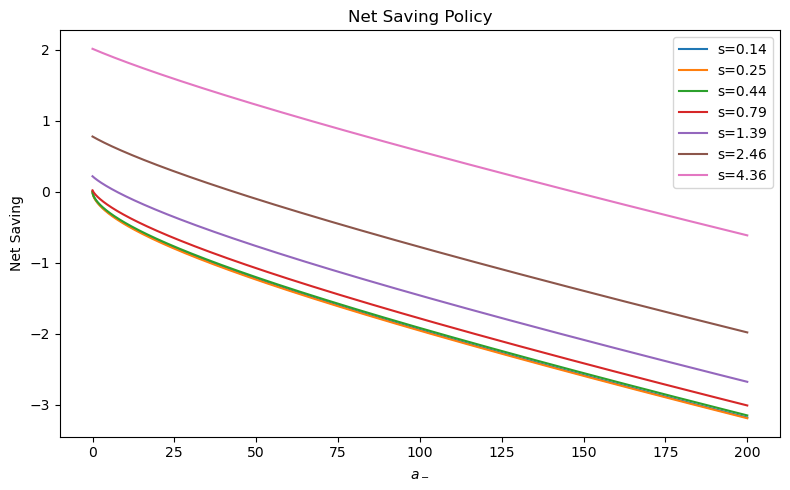

In [4]:

# -------------------------------------------------------------------------
# Figure 1: Net Saving Policy (Question 5)
# -------------------------------------------------------------------------
print("Generating Figure 1: Net Saving Policy...")
plt.figure(figsize=(8, 5))
net_saving = m.a_policy - m.a_grid
for i_s in range(num_s):
    plt.plot(m.a_grid, net_saving[i_s], label=f's={m.s_grid[i_s]:.2f}')
plt.legend()
plt.xlabel('$a_-$')
plt.ylabel('Net Saving')
plt.title('Net Saving Policy')
plt.tight_layout()
plt.savefig('fig_net_saving.pdf', bbox_inches='tight')
plt.show()
plt.close()


Generating Figure 2: Consumption Policy...


<Figure size 800x500 with 0 Axes>

Text(0.5, 0, '$a_-$')

Text(0, 0.5, 'Consumption')

Text(0.5, 1.0, 'Consumption Policy')

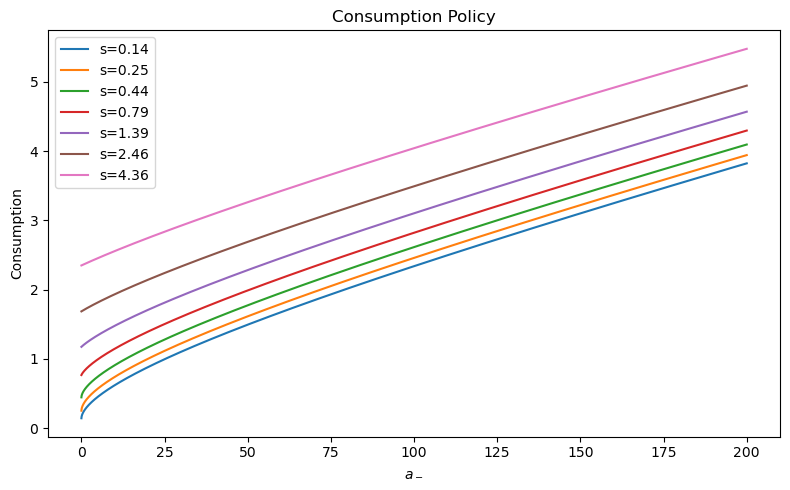

In [5]:

# -------------------------------------------------------------------------
# Figure 2: Consumption Policy (Question 5)
# -------------------------------------------------------------------------
print("Generating Figure 2: Consumption Policy...")
plt.figure(figsize=(8, 5))
for i_s in range(num_s):
    plt.plot(m.a_grid, m.c_policy[i_s], label=f's={m.s_grid[i_s]:.2f}')
plt.legend()
plt.xlabel('$a_-$')
plt.ylabel('Consumption')
plt.title('Consumption Policy')
plt.tight_layout()
plt.savefig('fig_consumption.pdf', bbox_inches='tight')
plt.show()
plt.close()


Generating Figure 3: Assets vs Beta...


  beta=0.950, A=0.0020, MPC=0.9824


  beta=0.955, A=0.0059, MPC=0.9523


  beta=0.960, A=0.0164, MPC=0.8943


  beta=0.965, A=0.0409, MPC=0.8634


  beta=0.970, A=0.0908, MPC=0.7035


  beta=0.975, A=0.1963, MPC=0.6205


  beta=0.980, A=0.4161, MPC=0.5226


  beta=0.985, A=0.8951, MPC=0.3106


  beta=0.990, A=2.1238, MPC=0.1963


  beta=0.995, A=7.3966, MPC=0.0535


<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'Aggregate Assets vs Discount Factor')

Text(0.5, 0, 'Discount Factor ($\\beta$)')

Text(0, 0.5, 'Aggregate Assets ($A$)')

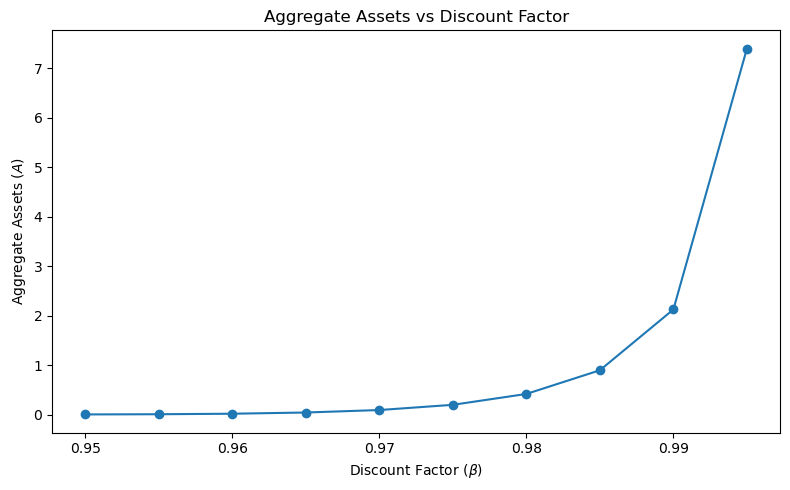

In [6]:

# -------------------------------------------------------------------------
# Figure 3 & 4: Comparative Statics with Beta (Question 10)
# -------------------------------------------------------------------------
print("Generating Figure 3: Assets vs Beta...")
beta_range = np.linspace(0.95, 0.995, 10)
MPC_range = np.zeros_like(beta_range)
A_range = np.zeros_like(beta_range)

for i, beta in enumerate(beta_range):
    m_temp = IncompleteMarketsModel(beta=beta)
    m_temp.solve()
    MPC_range[i] = m_temp.compute_MPC()
    A_range[i] = m_temp.compute_assets()
    print(f'  beta={beta:.3f}, A={A_range[i]:.4f}, MPC={MPC_range[i]:.4f}')

# Figure 3: Assets vs Beta
plt.figure(figsize=(8, 5))
plt.plot(beta_range, A_range, marker='o')
plt.title('Aggregate Assets vs Discount Factor')
plt.xlabel('Discount Factor ($\\beta$)')
plt.ylabel('Aggregate Assets ($A$)')
plt.tight_layout()
plt.savefig('fig_assets_beta.pdf', bbox_inches='tight')
plt.show()
plt.close()


Generating Figure 4: MPC vs Beta...


<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'Average MPC vs Discount Factor')

Text(0.5, 0, 'Discount Factor ($\\beta$)')

Text(0, 0.5, 'Average MPC')

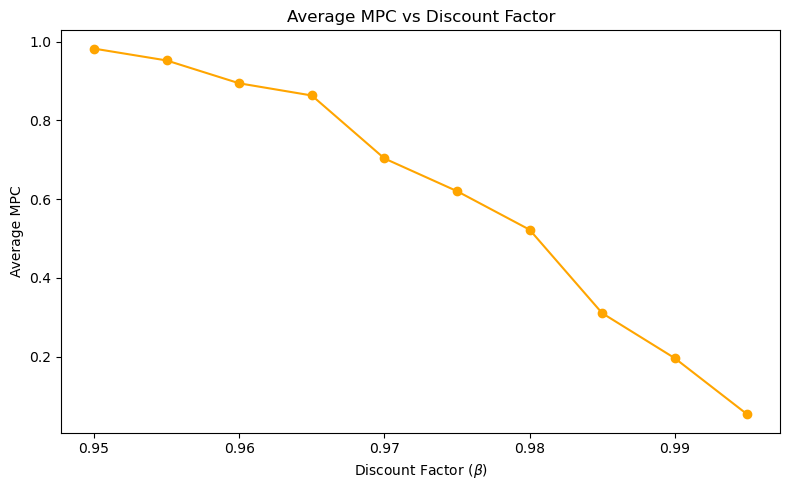

In [7]:

# Figure 4: MPC vs Beta
print("Generating Figure 4: MPC vs Beta...")
plt.figure(figsize=(8, 5))
plt.plot(beta_range, MPC_range, marker='o', color='orange')
plt.title('Average MPC vs Discount Factor')
plt.xlabel('Discount Factor ($\\beta$)')
plt.ylabel('Average MPC')
plt.tight_layout()
plt.savefig('fig_mpc_beta.pdf', bbox_inches='tight')
plt.show()
plt.close()


Generating Figure 5: Asset Distribution...


<Figure size 800x500 with 0 Axes>

<BarContainer object of 500 artists>

Text(0.5, 0, 'Assets')

Text(0, 0.5, 'Probability Mass')

Text(0.5, 1.0, 'Cross-sectional Asset Distribution')

(0.0, 200.0)

(0.0, 0.01)

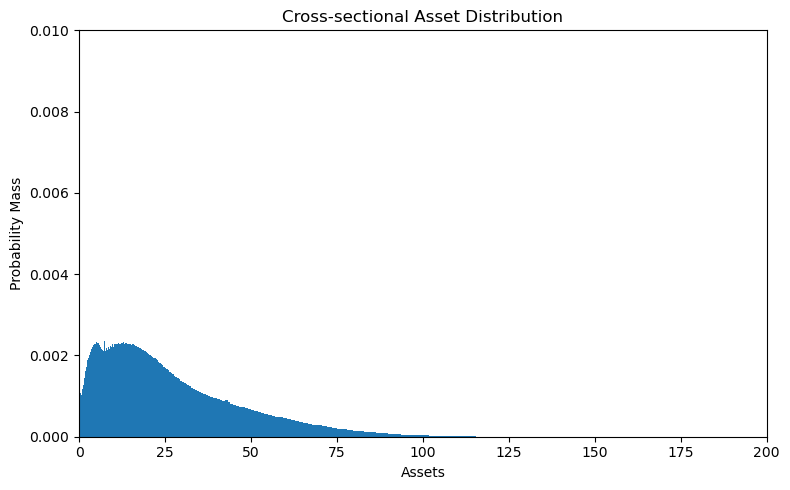

In [8]:

# -------------------------------------------------------------------------
# Figure 5: Cross-sectional Asset Distribution (Question 11)
# -------------------------------------------------------------------------
print("Generating Figure 5: Asset Distribution...")
plt.figure(figsize=(8, 5))
asset_dist = m.D.sum(axis=0)  # Marginal distribution over assets
plt.bar(m.a_grid, asset_dist, width=np.diff(m.a_grid, append=m.a_grid[-1]*1.01))
plt.xlabel('Assets')
plt.ylabel('Probability Mass')
plt.title('Cross-sectional Asset Distribution')
plt.xlim(0, 200)
plt.ylim(0, 0.01)
plt.tight_layout()
plt.savefig('fig_asset_dist.pdf', bbox_inches='tight')
plt.show()
plt.close()


In [9]:

# -------------------------------------------------------------------------
# Print Key Results (Question 9)
# -------------------------------------------------------------------------
print("\n" + "="*50)
print("KEY RESULTS (Baseline: beta=0.988)")
print("="*50)
A_baseline = m.compute_assets()
MPC_baseline = m.compute_MPC()
print(f"Aggregate Assets (A): {A_baseline:.4f}")
print(f"Average MPC: {MPC_baseline:.4f}")
print("="*50)

# print("\nAll figures saved successfully!")



KEY RESULTS (Baseline: beta=0.988)
Aggregate Assets (A): 1.4735
Average MPC: 0.2426
